In [16]:
import numpy as np
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from factor_analyzer import factor_analyzer, FactorAnalyzer
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
sensing_list=[]
for name in os.listdir("./StudentLife_Dataset/Inputs/sensing/"):
    if name.startswith('.'):
        continue
    sensing_list.append(name)

In [3]:
inputs = {}
num_quite={}
for name in sensing_list:
    
    li = []
    p=[]
    for j in range(60):
        if name == 'bluetooth':
            files = './StudentLife_Dataset/Clean_Dataset/Bluetooth/bluetooth.csv'
        else:
            files = './StudentLife_Dataset/Inputs/sensing/' + name + '/' + name + '_u' + str(f"{j:02d}") + '.csv'
        if  os.path.exists(files):
            #li.append(pd.read_csv(files, skip_blank_lines = False))
            li.append(pd.read_csv(files))
        else:
            li.append(None)
            p.append(j)
    inputs[name] = li
    num_quite[name] = p


In [4]:
### Load Data ###

In [5]:
flourishing = pd.read_csv('./StudentLife_Dataset/Outputs/FlourishingScale.csv')
panas = pd.read_csv('./StudentLife_Dataset/Outputs/panas.csv')
positive_score=['uid', 'Interested', 'Strong', 'Enthusiastic', 'Proud', 'Alert', 'Inspired', 'Determined ', 'Attentive', 'Active ']
negative_score=['uid', 'Distressed', 'Upset', 'Guilty', 'Scared', 'Hostile ', 'Irritable','Nervous', 'Jittery', 'Afraid ']
# panas_prescores = []
# panas_postscores = []
# flour_prescores = []
# flour_postscores = []
df_flour_pre = pd.DataFrame()
df_pos_pre = pd.DataFrame()
df_neg_pre = pd.DataFrame()
   
#     panas_prescores.append(panas.loc[panas['uid'] == 'u' + str(f"{i:02d}")].loc[panas['type'] == 'pre'])
#     panas_postscores.append(panas.loc[panas['uid'] == 'u' + str(f"{i:02d}")].loc[panas['type'] == 'post'])
#     flour_prescores.append(flourishing.loc[flourishing['uid'] == 'u' + str(f"{i:02d}")].loc[flourishing['type'] == 'pre'])
#     flour_postscores.append(flourishing.loc[flourishing['uid'] == 'u' + str(f"{i:02d}")].loc[flourishing['type'] == 'post'])
#     panas_prescores[i] = panas_prescores[i].drop(columns="uid")
#     panas_prescores[i] = panas_prescores[i].drop(columns="type")
#     panas_postscores[i] = panas_postscores[i].drop(columns="uid")
#     panas_postscores[i] = panas_postscores[i].drop(columns="type")
    
#     flour_prescores[i] = flour_prescores[i].drop(columns="uid")
#     flour_prescores[i] = flour_prescores[i].drop(columns="type")
#     flour_postscores[i] = flour_postscores[i].drop(columns="uid")
#     flour_postscores[i] = flour_postscores[i].drop(columns="type")
for i in range(60):
    temp_flour_pre = (flourishing.loc[flourishing['uid'] == 'u' + str(f"{i:02d}")].loc[flourishing['type'] == 'pre']).drop(columns='type')
    df_flour_pre = pd.concat([df_flour_pre, temp_flour_pre], axis = 0)
    
    temp_pre = panas.loc[panas['uid'] == 'u' + str(f"{i:02d}")].loc[panas['type'] == 'pre']
    df1_pre = temp_pre[positive_score]
    df2_pre = temp_pre[negative_score]
    df_pos_pre = pd.concat([df_pos_pre, df1_pre], axis=0)
    df_neg_pre = pd.concat([df_neg_pre, df2_pre], axis=0)
df_flour_pre = df_flour_pre.set_index(keys='uid')
df_pos_pre = df_pos_pre.set_index(keys='uid')
df_neg_pre = df_neg_pre.set_index(keys = 'uid')
#df_pos_pre

In [6]:
for j in inputs['gps'][0].index:
    inputs['gps'][0]
    if inputs['gps'][0] is not None:
        f = inputs['gps'][0]
        lat = f.loc[j][3]
        long = f.loc[j][4]

eigen value: [4.6081271  0.99307647 0.73236576 0.62128778 0.39448741 0.28179235
 0.19300244 0.17586069]
[[0.47353674 0.75449639 0.18555715 0.06187702]
 [0.15148117 0.66302237 0.39570113 0.30032666]
 [0.23867651 0.66023053 0.27250365 0.16489545]
 [0.20948833 0.37536675 0.7764718  0.20062113]
 [0.67183821 0.36053624 0.00522174 0.09449985]
 [0.58837221 0.31296333 0.49115735 0.12078883]
 [0.89809196 0.14908754 0.30432228 0.18075275]
 [0.17151183 0.1988925  0.17457098 0.94659907]]


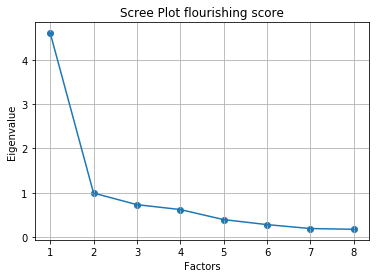

In [9]:
# ### Factor Analysis on flourishing score ###
fa = FactorAnalyzer(rotation='varimax', n_factors = 4)
fa.fit(df_flour_pre)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print('eigen value:',ev)
print(fa.loadings_)
fa.get_factor_variance()
fa.get_communalities()
#df_flour.corr()
plt.scatter(range(1,df_flour_pre.shape[1]+1),ev)
plt.plot(range(1,df_flour_pre.shape[1]+1),ev)
plt.title('Scree Plot flourishing score')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

[[ 0.13435839  0.21543195  0.19575419  0.90711699  0.26402304]
 [ 0.01843558  0.41769603  0.58065349  0.18066557  0.23898865]
 [ 0.27472303  0.79314079  0.25611116  0.2339755  -0.00982789]
 [ 0.24141884  0.64220543  0.09054653  0.05867983  0.19147233]
 [ 0.1143989   0.10379955  0.12250553  0.17008154  0.63550985]
 [ 0.63941798  0.11315271 -0.09166742  0.12922177  0.12428434]
 [ 0.73916912  0.2402917   0.29725787 -0.01316348  0.06845707]
 [ 0.66731095  0.42265593  0.45041359  0.09091923  0.01553593]
 [ 0.13140379  0.09042034  0.72868115  0.09193003  0.07222099]]


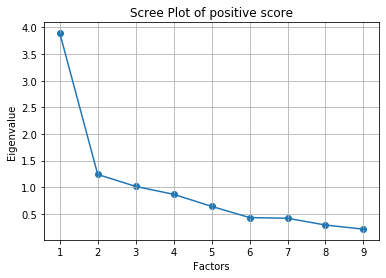

In [12]:
### Factor Analysis on positive score ###
fa = FactorAnalyzer(rotation='varimax', n_factors = 5)
fa.fit(df_pos_pre)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

print(fa.loadings_)
fa.get_factor_variance()
df_pos_pre.corr()
plt.scatter(range(1,df_pos_pre.shape[1]+1),ev)
plt.plot(range(1,df_pos_pre.shape[1]+1),ev)
plt.title('Scree Plot of positive score')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

[[ 0.26642058  0.68869953  0.06282944  0.17142685  0.24641543]
 [ 0.28523875  0.69737183  0.14439947  0.09157988  0.63289567]
 [ 0.53057551  0.01674618  0.06586591 -0.08172936  0.02948307]
 [ 0.76204749  0.1340622   0.14139619  0.23730891  0.15844704]
 [ 0.78852646  0.4033176   0.11078995 -0.24789998 -0.04994254]
 [ 0.09669945  0.89902013  0.10035553  0.08996662 -0.04382356]
 [-0.01370175  0.13027413  0.1558674   0.76058884  0.03319731]
 [ 0.18454197  0.13834839  0.95069172  0.18710944  0.05461554]
 [ 0.7283248   0.34850639  0.01005506  0.40388545  0.19944468]]


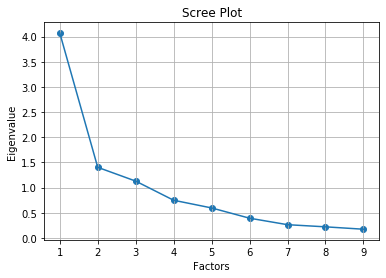

In [13]:
### Factor Analysis on negative score ###
fa = FactorAnalyzer(rotation='varimax', n_factors = 5)
fa.fit(df_neg_pre)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

print(fa.loadings_)
fa.get_factor_variance()
df_neg_pre.corr()
plt.scatter(range(1,df_neg_pre.shape[1]+1),ev)
plt.plot(range(1,df_neg_pre.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [14]:
### INPUT DATA ###

In [15]:
# # frequency of phone lock more than 1 hour
# df_lock = pd.DataFrame(columns = ['lock'])
# for i in range(60):
#     if inputs['phonelock'][i] is not None:
#         df_lock.loc[i] = [len(inputs['phonelock'][i])]
#         key = 'u'+str(f"{i:02d}") 
#         df_lock.rename(index={i:key}, inplace=True)

# # frequency of conversation more than 30 mins
# df_conversation = pd.DataFrame(columns=['conversation'])
# for i in range(60):
#     val = 0
#     if inputs['conversation'][i] is not None:
#         key = 'u' + str(f"{i:02d}")
#         for j in range(len(inputs['conversation'][i])):
#             if inputs['conversation'][i] is not None:
#                 f = inputs['conversation'][i].iloc[j,0]
#             ts1 = int(f)
            
#             h = datetime.utcfromtimestamp(ts1).hour
#             if (inputs['conversation'][i].iloc[j,1] - inputs['conversation'][i].iloc[j,0])/60 > 30:
#                 val +=1
    
#         #df_conversation.loc[i] = np.sum(inputs['conversation'][i].iloc[:,1] - inputs['conversation'][i].iloc[:,0])
#         df_conversation.loc[i] = val
#         df_conversation.rename(index={i:key}, inplace=True)

# # the number of activity recorded for each person is not the same. if we want to use activity as our feature,
# # maybe better to use as percentage
# df_run = pd.DataFrame(columns=['run'])
# for i in range(60):
#     if inputs['activity'][i] is not None:
#         res = np.unique(inputs['activity'][i].iloc[:, 1], return_counts=True)
#         running = 2
#         df_run.loc['u'+str(f"{i:02d}")] = res[1][running]/sum(res[1])

# df_walk = pd.DataFrame(columns=['walk'])
# for i in range(60):
#     if inputs['activity'][i] is not None:
#         res = np.unique(inputs['activity'][i].iloc[:, 1], return_counts=True)
#         walking = 1
#         df_walk.loc['u'+str(f"{i:02d}")] = res[1][walking]/sum(res[1])
        
# # approximation of total sleeping time for each candidate
# df_sleep = pd.DataFrame(columns=['sleep'])
# for i in range(60):
#     val = 0
#     if inputs['dark'][i] is not None:
#         key = 'u' + str(f"{i:02d}")
#         for j in range(len(inputs['dark'][i])):
#             if inputs['dark'][i] is not None:
#                 start = inputs['dark'][i].iloc[j,0]
#                 end = inputs['dark'][i].iloc[j,1]
#             ts1 = int(start)
#             ts2 = int(end)
#             h1 = datetime.utcfromtimestamp(ts1).hour
#             h2 = datetime.utcfromtimestamp(ts2).hour
#             if (h1 >= 0 and h1<=8) or (h2 >=0 and h1<=8):
#                 # phone is in dark for more than 3 hours
#                 if end - start >= 2:
#                     val += end - start
#                     #val +=1
#         df_sleep.loc[i] = val
#         df_sleep.rename(index={i:key}, inplace=True)

# # candidate using wifi indoor 
# df_wifi_location = pd.DataFrame(columns=['location'])
# for i in range(60):
#     val = 0
#     if inputs['wifi_location'][i] is not None:
#         key = 'u' + str(f"{i:02d}")
#         for j in range(len(inputs['wifi_location'][i])):
#             if 'in[' in inputs['wifi_location'][i].iloc[j, 0]:
#                 val +=1
#         df_wifi_location.loc[key] = val/len(inputs['wifi_location'][i])

# # proportion of time that candidate in noisy environment
# df_noise = pd.DataFrame(columns=['noise'])
# for i in range(60):
#     if inputs['audio'][i] is not None:
#         res = np.unique(inputs['audio'][i].iloc[:, 1], return_counts=True)
#         noise = 2
#         df_noise.loc['u'+str(f"{i:02d}")] = res[1][noise]/sum(res[1])

In [18]:
inputs['conversation'][0]

,start_timestamp,end_timestamp
0,1364359600,1364359812
1,1364382621,1364383065
2,1364383516,1364384993
3,1364385033,1364385094
4,1364385786,1364385866
...,...,...
2106,1370037443,1370037604
2107,1370037874,1370038710
2108,1370038931,1370044458
2109,1370044688,1370048026


In [ ]:
# Time Series 
lstm = nn.LSTM(3, 3)
data = [torch.tensor(inputs['conversation'][0]) for _ in range(10)]

In [9]:
### BINARIZATION ###

In [23]:
### Convert score to binary data ###
def binarize(df, threshold):
    m = threshold
    if m < 1:
        df[df.iloc[:, 0] > m] = 1
        df[df.iloc[:, 0] <= m] = 0
    else:
        df[df.iloc[:, 0] <= m] = 0
        df[df.iloc[:, 0] > m] = 1
    return df

In [643]:
df_flour_change[df_flour_change.iloc[:, 0] > (-2)] = 1
df_flour_change[df_flour_change.iloc[:, 0] <= (-2)] = 0

#df_flour_change


In [24]:
# ### Defining Classes ###
# df_total_flour[df_total_flour.iloc[:, 0] <= m] = 0
# df_total_flour[df_total_flour.iloc[:, 0] > m] = 1 
# df_class = pd.DataFrame(columns=['class'])
# for uid in df_total_flour.index:
#     s1 = int(df_total_flour.loc[uid])
#     s2 = int(df_pos_post.loc[uid])
#     if s1 is None or s2 is None:
#         continue

#     # No confidence and Negative
#     if s1 == 0 and s2 == 0:
#         df_class.loc[uid] = 1.0
#     # confidence and Negative
#     if s1 == 1 and s2==0:
#         df_class.loc[uid] = 2.0
#     # No confidence and Positive
#     if s1 == 0 and s2==1:
#         df_class.loc[uid] = 3.0
#     # confidence and Positive
#     if s1 == 1 and s2==1:
#         df_class.loc[uid] = 4.0
#df_class

In [442]:
### METHODS ###

In [29]:
### KNN ###
### Binary ###
def KNN(features, y, n_neighbour):
    X_train, X_test, y_train, y_test = train_test_split(features, y.to_numpy().ravel())
    neighbour = KNeighborsClassifier(n_neighbors=n_neighbour).fit(X_train, y_train)
    pred = neighbour.predict(X_test)
    print('accuracy:',  accuracy_score(y_test, pred))


In [103]:
### Evaluation Metrics For KNN ###
### ROC AUC ###
def roc_auc_comparison(features, y):
    n = 3
    kf = KFold(n_splits=n)
    scores = []
    for i in range(2,10):
        score = 0
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = features.iloc[train, :], features.iloc[test, :], y.to_numpy().ravel()[train], y.to_numpy().ravel()[test]
            
            model = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
            pred = model.predict(X_test)
            
#             print(y_test)
#             print(pred)
            score += roc_auc_score(y_test, pred)
        scores.append(score/n)
    n_neighbour = np.asarray(scores).argmax()+2
    print('optimal k:', n_neighbour)
    plt.plot(scores)
    return n_neighbour



def accuracy_comparison(features, y):
    n = 4
    kf = KFold(n_splits=n)
    scores = []
    for i in range(2,10):
        score = 0
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = features.iloc[train, :], features.iloc[test, :], y.to_numpy().ravel()[train], y.to_numpy().ravel()[test]
            model = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
            pred = model.predict(X_test)
            score += accuracy_score(y_test, pred)
        scores.append(score/n)
    n_neighbour = np.asarray(scores).argmax()+2
    print('optimal k:', n_neighbour)
    plt.plot(scores)
    return n_neighbour

In [101]:
df_sleep.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
df_run.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
df_walk.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
df_conversation.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
df_noise.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
df_lock.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
new_df_bt.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

,frequency
u00,0.444444
u01,0.111111
u02,0.333333
u03,0
u04,0.111111
u05,0.777778
u07,0.222222
u08,0.444444
u09,0.333333
u10,0.666667


optimal k: 7
accuracy: 0.6666666666666666


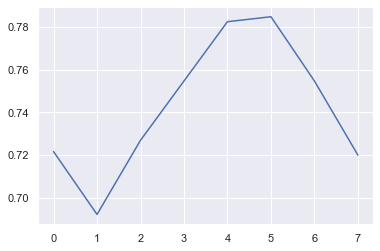

In [208]:
new_df_lock = pd.DataFrame(columns = ['lock'])
new_df_conversation = pd.DataFrame(columns = ['conversation'])
new_df_walk = pd.DataFrame(columns = ['walk'])
new_df_run = pd.DataFrame(columns = ['run'])
new_df_sleep = pd.DataFrame(columns = ['sleep'])
new_df_bt = pd.DataFrame(columns=['frequency'])
new_df_wifi_location = pd.DataFrame(columns = ['location'])
df_bt = inputs['bluetooth'][0].set_index('uid')
new_df_noise = pd.DataFrame(columns=['noise'])
for uid in df_pos_pre.index:
    new_df_lock.loc[uid] = df_lock.loc[uid]
    new_df_conversation.loc[uid] = df_conversation.loc[uid]
    new_df_sleep.loc[uid] = df_sleep.loc[uid]
    new_df_bt.loc[uid] = df_bt.loc[uid]
    new_df_walk.loc[uid] = df_walk.loc[uid]
    new_df_run.loc[uid] = df_run.loc[uid]
    new_df_wifi_location.loc[uid] = df_wifi_location.loc[uid]
    new_df_noise.loc[uid] = df_noise.loc[uid]
#new_df_bt
X = pd.concat([new_df_bt, new_df_conversation], axis = 1)
#n_neighbour = roc_auc_comparison(X, df_pos_pre)
# df = pd.DataFrame(columns = ['sum'])
#df = df_flour_pre.iloc[:, 4:7].fillna(0).sum(axis=1)
#df = pd.DataFrame(df, columns=['total'])
df =df_flour_pre.iloc[:, 3:4].fillna(0)
df.columns = ['total']

# df
df = binarize(df, 5)
n_neighbour = roc_auc_comparison(X, df)
KNN(X, df, n_neighbour=n_neighbour)

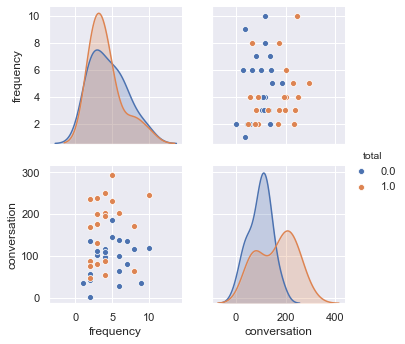

In [209]:
import seaborn as sns

X = X.astype('float')
tempX = pd.concat([X, df], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('total')
sns.pairplot(tempX, hue = 'total', vars = var)
plt.show()

In [26]:
df_pos_pre.index

Index(['u00', 'u01', 'u02', 'u03', 'u04', 'u05', 'u07', 'u08', 'u09', 'u10',
       'u12', 'u13', 'u14', 'u15', 'u16', 'u17', 'u18', 'u19', 'u20', 'u22',
       'u23', 'u24', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36',
       'u39', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47', 'u49', 'u50', 'u51',
       'u52', 'u53', 'u56', 'u57', 'u58', 'u59'],
      dtype='object', name='uid')

optimal k: 7
accuracy: 0.8


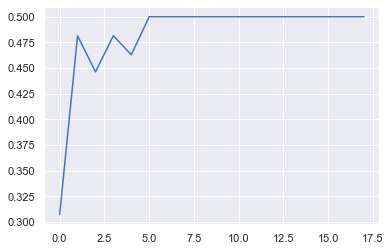

In [622]:
new_df_lock = pd.DataFrame(columns = ['lock'])
new_df_conversation = pd.DataFrame(columns = ['conversation'])
new_df_walk = pd.DataFrame(columns = ['walk'])
new_df_run = pd.DataFrame(columns = ['run'])
new_df_sleep = pd.DataFrame(columns = ['sleep'])
new_df_bt = pd.DataFrame(columns=['frequency'])
new_df_wifi_location = pd.DataFrame(columns = ['location'])
df_bt = inputs['bluetooth'][0].set_index('uid')
new_df_noise = pd.DataFrame(columns=['noise'])
for uid in df_flour_change.index:
    new_df_lock.loc[uid] = df_lock.loc[uid]
    new_df_conversation.loc[uid] = df_conversation.loc[uid]
    new_df_sleep.loc[uid] = df_sleep.loc[uid]
    new_df_bt.loc[uid] = df_bt.loc[uid]
    new_df_walk.loc[uid] = df_walk.loc[uid]
    new_df_run.loc[uid] = df_run.loc[uid]
    new_df_wifi_location.loc[uid] = df_wifi_location.loc[uid]
    new_df_noise.loc[uid] = df_noise.loc[uid]
    
#new_df_bt
X = pd.concat([new_df_sleep, new_df_wifi_location], axis = 1)
n_neighbour = roc_auc_comparison(X, df_flour_change)
#n_neighbour = accuracy_comparison(X, df_total_flour)
KNN(X, df_flour_change, n_neighbour=n_neighbour)

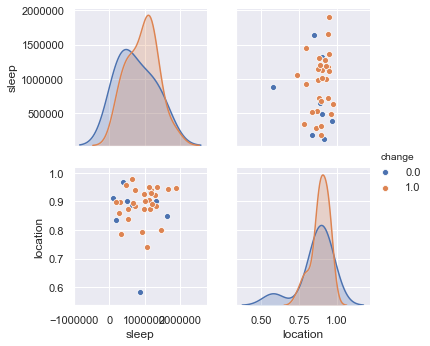

In [623]:
tempX = pd.concat([X, df_flour_change], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('change')
sns.pairplot(tempX, hue = 'change', vars = var)
plt.show()

In [368]:
np.unique(df_total_flour, return_counts = True)
np.unique(df_class, return_counts = True)

(array([1., 3.]), array([22, 15]))

(array([1., 3.]), array([22, 15]))


([<matplotlib.patches.Wedge at 0x15cee37f0>,
 [Text(-0.3221050590501589, 1.0517834049528894, '1.0'),
  Text(0.3221050590501588, -1.0517834049528896, '3.0')])

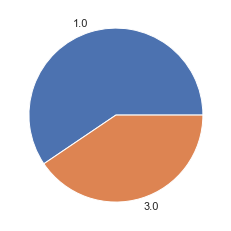

In [369]:
# classes
a = np.unique(df_class, return_counts=True)
print(a)
label = a[0]
y = a[1]
plt.pie(y, labels=label)

In [370]:
# new_df_lock = pd.DataFrame(columns = ['freq'])
# new_df_conversation = pd.DataFrame(columns = ['time'])
# new_df_sleep = pd.DataFrame(columns = ['time'])
# for uid in df_class.index:
#     new_df_lock.loc[uid] = df_lock.loc[uid]
#     new_df_conversation.loc[uid] = df_conversation.loc[uid]
#     new_df_sleep.loc[uid] = df_sleep.loc[uid]
# # n_neighbour = roc_auc_comparison(X, df_class)
# # KNN(X, df_class, n_neighbour)
# X_train, X_test, y_train, y_test = train_test_split(X, df_class.to_numpy().ravel(), random_state=10)
# clf = BernoulliNB()
# clf.fit(X_train,y_train)
# pred = clf.predict(X_test)
# pred = pred.astype(int)
# pred

In [371]:
y_test = y_test.astype(int)
y_test
print(y_test)

print(accuracy_score(y_test, pred))

NameError: name 'y_test' is not defined

In [373]:
#inputs[''][2].head(50)

In [374]:
inputs.keys()

dict_keys(['wifi', 'gps', 'activity', 'phonelock', 'wifi_location', 'audio', 'bluetooth', 'dark', 'phonecharge', 'conversation'])

In [466]:
X = X.astype(dtype = 'float')
## correlation ##
c = X.corr()
c

,conversation,walk
conversation,1.000000,0.546159
walk,0.546159,1.000000


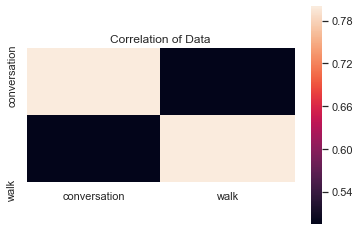

In [456]:
import seaborn as sns
sns.heatmap(c, vmax=.8, square=True)
plt.title("Correlation of Data")
plt.show()

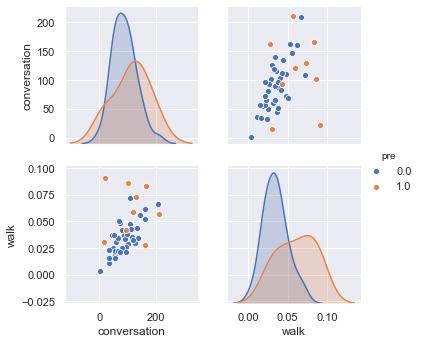

In [457]:
tempX = pd.concat([X, df_pos_pre], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('pre')
sns.pairplot(tempX, hue = 'pre', vars = var)
plt.show()

In [398]:
tempX

,conversation,sleep,pre
u00,230.0,923843.0,1.0
u01,235.0,1054239.0,0.0
u02,202.0,1635918.0,0.0
u03,36.0,380273.0,1.0
u04,136.0,1451965.0,0.0
u05,172.0,1129688.0,1.0
u07,103.0,1156834.0,0.0
u08,186.0,1468804.0,1.0
u09,249.0,717593.0,0.0
u10,136.0,1281413.0,1.0


In [145]:
df_flour_pre

,I lead a purposeful and meaningful life,My social relationships are supportive and rewarding,I am engaged and interested in my daily activities,I actively contribute to the happiness and well-being of others,I am competent and capable in the activities that are important to me,I am a good person and live a good life,I am optimistic about my future,People respect me
uid,,,,,,,,
u00,7,6,NaN,6.0,6.0,7.0,7,4
u01,4,6,6.0,6.0,7.0,6.0,4,6
u02,6,7,5.0,6.0,5.0,6.0,4,7
u03,6,2,2.0,4.0,5.0,6.0,5,4
u04,3,5,4.0,3.0,2.0,2.0,3,5
u05,6,6,6.0,6.0,6.0,6.0,6,6
u07,7,5,6.0,5.0,7.0,7.0,7,5
u08,5,5,5.0,5.0,5.0,NaN,4,4
u09,5,4,6.0,6.0,6.0,7.0,7,5


In [146]:
df_pos_pre

,Interested,Strong,Enthusiastic,Proud,Alert,Inspired,Determined,Attentive,Active
uid,,,,,,,,,
u00,5,4,3,3,4,4.0,4,3.0,2
u01,4,2,3,3,4,3.0,4,3.0,4
u02,4,2,3,2,3,2.0,2,3.0,2
u03,4,4,3,1,5,3.0,3,3.0,4
u04,4,3,3,3,3,1.0,3,3.0,4
u05,4,4,4,2,4,3.0,3,4.0,4
u07,3,4,4,5,3,2.0,3,3.0,3
u08,3,3,3,3,3,3.0,5,3.0,4
u09,4,3,3,3,3,2.0,3,3.0,4


In [ ]:
# ### Componenet Analysis on flourishing score ###
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_flour)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_

# ### Componenet Analysis on positive score ###
# df_pos = df_pos.fillna(0)
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_pos)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_

# ### Componenet Analysis on negative score ###
# df_neg = df_neg.fillna(0)
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_neg)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_